In [194]:
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path



In [195]:
matches = pd.read_csv('../data/merged_after_odds.csv', index_col=False)



In [196]:
required_columns = [
    "Date", "HomeTeam", "AwayTeam", "FTHG", "FTAG"
]
missing_columns = [col for col in required_columns if col not in matches.columns]
if missing_columns:
    raise ValueError(f"Missing required columns in source data: {missing_columns}")

initial_rows = len(matches)
print(f"Initial rows: {initial_rows}")

# Deduplicate fixtures based on unique date/home/away combination
duplicate_mask = matches.duplicated(subset=["Date", "HomeTeam", "AwayTeam"], keep="first")
duplicates_removed = int(duplicate_mask.sum())
if duplicates_removed:
    matches = matches.loc[~duplicate_mask].copy()
    print(f"Removed {duplicates_removed} duplicated fixture rows; {len(matches)} rows remain.")
else:
    print("No duplicated fixture rows detected.")

# Basic sanity checks for match stat completeness (odds excluded)
quality_columns = ["FTHG", "FTAG", "HS", "AS", "HST", "AST", "HC", "AC", "HF", "AF", "HY", "AY", "HR", "AR"]
missing_rows_mask = matches[quality_columns].isna().any(axis=1)
missing_rows = int(missing_rows_mask.sum())
if missing_rows:
    print(f"Removing {missing_rows} rows with missing crucial stats; displaying column counts below.")
    display(matches.loc[missing_rows_mask, quality_columns].isna().sum())
    matches = matches.loc[~missing_rows_mask].copy()
    print(f"Rows remaining after dropping missing stats: {len(matches)}")
else:
    print("No missing crucial stats detected.")

# Ensure Date parsed correctly and drop rows with invalid dates
matches["Date"] = pd.to_datetime(matches["Date"], errors="coerce")
invalid_dates = int(matches["Date"].isna().sum())
if invalid_dates:
    matches = matches.dropna(subset=["Date"])
    print(f"Removed {invalid_dates} rows with invalid dates; {len(matches)} rows remain.")
else:
    print("All rows contain valid dates.")


Initial rows: 9270
No duplicated fixture rows detected.
No missing crucial stats detected.
All rows contain valid dates.


In [197]:
# Additional sanity checks on numeric ranges and team label consistency
count_columns = [
    "FTHG", "FTAG", "HS", "AS", "HST", "AST", "HC", "AC",
    "HF", "AF", "HY", "AY", "HR", "AR"
]
negative_mask = (matches[count_columns] < 0)
if negative_mask.any().any():
    problematic_cols = negative_mask.any(axis=0)
    raise ValueError(f"Negative values found in match stats: {list(problematic_cols[problematic_cols].index)}")
else:
    print("Verified non-negative counts for goals, shots, cards, and fouls.")

home_teams = set(matches["HomeTeam"].unique())
away_teams = set(matches["AwayTeam"].unique())
extra_home = sorted(home_teams - away_teams)
extra_away = sorted(away_teams - home_teams)
if extra_home or extra_away:
    print("Warning: Team naming mismatch detected between home and away columns.")
    display({"only_home": extra_home, "only_away": extra_away})
else:
    print("Home/Away team name sets match exactly.")


Verified non-negative counts for goals, shots, cards, and fouls.
Home/Away team name sets match exactly.


In [198]:
# Persist a stable match identifier for downstream joins
matches = matches.sort_values("Date").reset_index(drop=True)
matches["match_id"] = matches.index
matches.head()


,Date,Div,HomeTeam,AwayTeam,FTHG,FTAG,HTHG,HTAG,FTR,HS,...,HF,AF,HY,AY,HR,AR,B365H,B365D,B365A,match_id
0,2000-01-10,E0,Chelsea,Liverpool,3,0,2,0,H,11,...,14,14,1,1,0,0,NaN,NaN,NaN,0
1,2000-01-10,E0,Sunderland,Leicester,0,0,0,0,D,11,...,12,8,3,1,0,0,NaN,NaN,NaN,1
2,2000-01-10,E0,Arsenal,Man United,1,0,1,0,H,7,...,18,17,2,3,0,0,NaN,NaN,NaN,2
3,2000-02-12,E0,West Ham,Middlesbrough,1,0,1,0,H,14,...,17,19,1,4,0,1,NaN,NaN,NaN,3
4,2000-02-12,E0,Man United,Tottenham,2,0,1,0,H,16,...,7,8,2,1,0,0,NaN,NaN,NaN,4


In [199]:
matches.shape


(9270, 25)

In [200]:
matches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9270 entries, 0 to 9269
Data columns (total 25 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      9270 non-null   datetime64[ns]
 1   Div       9270 non-null   object        
 2   HomeTeam  9270 non-null   object        
 3   AwayTeam  9270 non-null   object        
 4   FTHG      9270 non-null   int64         
 5   FTAG      9270 non-null   int64         
 6   HTHG      9270 non-null   int64         
 7   HTAG      9270 non-null   int64         
 8   FTR       9270 non-null   object        
 9   HS        9270 non-null   int64         
 10  AS        9270 non-null   int64         
 11  HST       9270 non-null   int64         
 12  AST       9270 non-null   int64         
 13  HC        9270 non-null   int64         
 14  AC        9270 non-null   int64         
 15  HF        9270 non-null   int64         
 16  AF        9270 non-null   int64         
 17  HY        9270

In [201]:
# Preview shown earlier; redundant cell removed.

In [202]:
# Tail preview omitted to reduce noise.

In [203]:
# Removed unused exploratory calculation.

In [204]:
# Shape already captured earlier.

In [205]:
matches['HomeTeam'].value_counts()

HomeTeam
Chelsea             465
Everton             465
Arsenal             464
Man United          463
Liverpool           462
Tottenham           462
Man City            445
Newcastle           426
Aston Villa         418
West Ham            408
Fulham              335
Southampton         305
Sunderland          272
West Brom           247
Crystal Palace      235
Leicester           230
Blackburn           209
Bolton              209
Wolves              197
Stoke               190
Middlesbrough       171
Burnley             159
Wigan               152
Bournemouth         141
Brighton            139
Leeds               138
Birmingham          133
Swansea             133
Portsmouth          133
Charlton            133
Norwich             127
Watford             116
Hull                 95
Brentford            82
Sheffield United     70
Nott'm Forest        63
Ipswich              57
QPR                  57
Derby                57
Reading              57
Cardiff              28
Hudders

### The data type of each columns


In [206]:
# Data types captured above via matches.info().

In [207]:
# Date summary available via validations above.

In [208]:
# Duplicate dtype display removed.


In [209]:
# Preview already shown once.

In [210]:
# Legacy home/away reshaping removed – matches_long below now powers the modeling pipeline.


In [211]:
teams_index = pd.Index(pd.concat([matches["HomeTeam"], matches["AwayTeam"]], ignore_index=True).unique())
team_code_map = {team: idx for idx, team in enumerate(sorted(teams_index))}
matches["home_code"] = matches["HomeTeam"].map(team_code_map)
matches["away_code"] = matches["AwayTeam"].map(team_code_map)
matches["day_code"] = matches["Date"].dt.dayofweek

In [212]:
# Encoded team/day features above.

In [213]:
matches.head()

,Date,Div,HomeTeam,AwayTeam,FTHG,FTAG,HTHG,HTAG,FTR,HS,...,AY,HR,AR,B365H,B365D,B365A,match_id,home_code,away_code,day_code
0,2000-01-10,E0,Chelsea,Liverpool,3,0,2,0,H,11,...,1,0,0,NaN,NaN,NaN,0,13,24,0
1,2000-01-10,E0,Sunderland,Leicester,0,0,0,0,D,11,...,1,0,0,NaN,NaN,NaN,1,39,23,0
2,2000-01-10,E0,Arsenal,Man United,1,0,1,0,H,7,...,3,0,0,NaN,NaN,NaN,2,0,27,0
3,2000-02-12,E0,West Ham,Middlesbrough,1,0,1,0,H,14,...,4,0,1,NaN,NaN,NaN,3,44,29,5
4,2000-02-12,E0,Man United,Tottenham,2,0,1,0,H,16,...,1,0,0,NaN,NaN,NaN,4,27,41,5


In [214]:
matches.tail()

,Date,Div,HomeTeam,AwayTeam,FTHG,FTAG,HTHG,HTAG,FTR,HS,...,AY,HR,AR,B365H,B365D,B365A,match_id,home_code,away_code,day_code
9265,2025-11-09,E0,Brentford,Newcastle,3,1,0,1,H,15,...,1,0,0,2.80,3.50,2.45,9265,8,30,6
9266,2025-11-09,E0,Crystal Palace,Brighton,0,0,0,0,D,10,...,4,0,0,2.25,3.50,3.10,9266,15,9,6
9267,2025-11-09,E0,Nott'm Forest,Leeds,3,1,1,1,H,14,...,1,0,0,2.25,3.25,3.30,9267,32,22,6
9268,2025-11-09,E0,Aston Villa,Bournemouth,4,0,2,0,H,16,...,2,0,0,2.20,3.40,3.25,9268,1,6,6
9269,2025-11-09,E0,Man City,Liverpool,3,0,2,0,H,14,...,4,0,0,1.90,3.90,3.70,9269,26,24,6


In [215]:
matches.shape

(9270, 28)

## Created a result column to add W for Home Win and L for Home Loss

In [216]:
matches["result"] = matches.apply(
    lambda row: "W" if row["FTHG"] > row["FTAG"] 
                else ("L" if row["FTHG"] < row["FTAG"] else "D"),
    axis=1
)

In [217]:
matches.head()

,Date,Div,HomeTeam,AwayTeam,FTHG,FTAG,HTHG,HTAG,FTR,HS,...,HR,AR,B365H,B365D,B365A,match_id,home_code,away_code,day_code,result
0,2000-01-10,E0,Chelsea,Liverpool,3,0,2,0,H,11,...,0,0,NaN,NaN,NaN,0,13,24,0,W
1,2000-01-10,E0,Sunderland,Leicester,0,0,0,0,D,11,...,0,0,NaN,NaN,NaN,1,39,23,0,D
2,2000-01-10,E0,Arsenal,Man United,1,0,1,0,H,7,...,0,0,NaN,NaN,NaN,2,0,27,0,W
3,2000-02-12,E0,West Ham,Middlesbrough,1,0,1,0,H,14,...,0,1,NaN,NaN,NaN,3,44,29,5,W
4,2000-02-12,E0,Man United,Tottenham,2,0,1,0,H,16,...,0,0,NaN,NaN,NaN,4,27,41,5,W


In [218]:
matches['target'] = (matches['result']== 'W').astype('int')

In [219]:
label_map = {"W": 0, "D": 1, "L": 2}
matches["result_label"] = matches["result"].map(label_map)
label_map


{'W': 0, 'D': 1, 'L': 2}

In [220]:
# Map match results into multi-class labels for home win / draw / away win
label_map = {"W": 0, "D": 1, "L": 2}
matches["result_label"] = matches["result"].map(label_map)
label_map


{'W': 0, 'D': 1, 'L': 2}

In [221]:
matches.head()

,Date,Div,HomeTeam,AwayTeam,FTHG,FTAG,HTHG,HTAG,FTR,HS,...,B365H,B365D,B365A,match_id,home_code,away_code,day_code,result,target,result_label
0,2000-01-10,E0,Chelsea,Liverpool,3,0,2,0,H,11,...,NaN,NaN,NaN,0,13,24,0,W,1,0
1,2000-01-10,E0,Sunderland,Leicester,0,0,0,0,D,11,...,NaN,NaN,NaN,1,39,23,0,D,0,1
2,2000-01-10,E0,Arsenal,Man United,1,0,1,0,H,7,...,NaN,NaN,NaN,2,0,27,0,W,1,0
3,2000-02-12,E0,West Ham,Middlesbrough,1,0,1,0,H,14,...,NaN,NaN,NaN,3,44,29,5,W,1,0
4,2000-02-12,E0,Man United,Tottenham,2,0,1,0,H,16,...,NaN,NaN,NaN,4,27,41,5,W,1,0


In [222]:
matches.tail()


,Date,Div,HomeTeam,AwayTeam,FTHG,FTAG,HTHG,HTAG,FTR,HS,...,B365H,B365D,B365A,match_id,home_code,away_code,day_code,result,target,result_label
9265,2025-11-09,E0,Brentford,Newcastle,3,1,0,1,H,15,...,2.80,3.50,2.45,9265,8,30,6,W,1,0
9266,2025-11-09,E0,Crystal Palace,Brighton,0,0,0,0,D,10,...,2.25,3.50,3.10,9266,15,9,6,D,0,1
9267,2025-11-09,E0,Nott'm Forest,Leeds,3,1,1,1,H,14,...,2.25,3.25,3.30,9267,32,22,6,W,1,0
9268,2025-11-09,E0,Aston Villa,Bournemouth,4,0,2,0,H,16,...,2.20,3.40,3.25,9268,1,6,6,W,1,0
9269,2025-11-09,E0,Man City,Liverpool,3,0,2,0,H,14,...,1.90,3.90,3.70,9269,26,24,6,W,1,0


In [223]:
matches[["match_id", "Date"]].tail()

,match_id,Date
9265,9265,2025-11-09
9266,9266,2025-11-09
9267,9267,2025-11-09
9268,9268,2025-11-09
9269,9269,2025-11-09


In [224]:
matches.tail()

,Date,Div,HomeTeam,AwayTeam,FTHG,FTAG,HTHG,HTAG,FTR,HS,...,B365H,B365D,B365A,match_id,home_code,away_code,day_code,result,target,result_label
9265,2025-11-09,E0,Brentford,Newcastle,3,1,0,1,H,15,...,2.80,3.50,2.45,9265,8,30,6,W,1,0
9266,2025-11-09,E0,Crystal Palace,Brighton,0,0,0,0,D,10,...,2.25,3.50,3.10,9266,15,9,6,D,0,1
9267,2025-11-09,E0,Nott'm Forest,Leeds,3,1,1,1,H,14,...,2.25,3.25,3.30,9267,32,22,6,W,1,0
9268,2025-11-09,E0,Aston Villa,Bournemouth,4,0,2,0,H,16,...,2.20,3.40,3.25,9268,1,6,6,W,1,0
9269,2025-11-09,E0,Man City,Liverpool,3,0,2,0,H,14,...,1.90,3.90,3.70,9269,26,24,6,W,1,0


In [225]:
matches.dtypes

Date            datetime64[ns]
Div                     object
HomeTeam                object
AwayTeam                object
FTHG                     int64
FTAG                     int64
HTHG                     int64
HTAG                     int64
FTR                     object
HS                       int64
AS                       int64
HST                      int64
AST                      int64
HC                       int64
AC                       int64
HF                       int64
AF                       int64
HY                       int64
AY                       int64
HR                       int64
AR                       int64
B365H                  float64
B365D                  float64
B365A                  float64
match_id                 int64
home_code                int64
away_code                int64
day_code                 int32
result                  object
target                   int64
result_label             int64
dtype: object

In [226]:
# training on 2000–2016, testing on 2017–2018
train = matches[matches["Date"] < "2017-01-01"]
test  = matches[matches["Date"] >= "2017-01-01"]



In [227]:
matches.columns.tolist()


['Date',
 'Div',
 'HomeTeam',
 'AwayTeam',
 'FTHG',
 'FTAG',
 'HTHG',
 'HTAG',
 'FTR',
 'HS',
 'AS',
 'HST',
 'AST',
 'HC',
 'AC',
 'HF',
 'AF',
 'HY',
 'AY',
 'HR',
 'AR',
 'B365H',
 'B365D',
 'B365A',
 'match_id',
 'home_code',
 'away_code',
 'day_code',
 'result',
 'target',
 'result_label']

In [228]:
train.shape

(6268, 31)

In [229]:
test.shape

(3002, 31)

In [230]:
predictors = ["home_code", "away_code", "day_code"]

In [231]:
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

In [232]:
model = xgb.XGBClassifier(n_estimators=200, random_state= 42, eta = 0.01)



In [233]:
model.fit(train[predictors], train["target"])


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [234]:
preds = model.predict(test[predictors])


preds

array([1, 0, 0, ..., 0, 1, 0], shape=(3002,))

In [235]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, log_loss, ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, TimeSeriesSplit
import joblib

In [236]:
acc = accuracy_score(test["target"], preds)


In [237]:
acc

0.6382411725516323

In [238]:
combined = pd.DataFrame(dict(actual = test["target"], prediction = preds))

In [239]:
pd.crosstab(index=combined["actual"], columns=combined["prediction"])

prediction,0,1
actual,,
0,1328,342
1,744,588


In [240]:
# Metrics imported above.

In [241]:
# Placeholder – the multi-class section has been moved below the feature-engineering pipeline so
# all required variables (matches_model, feature_cols, etc.) are defined before use.


## Multi-class kick-off style predictions


In [242]:
# Placeholder for relocated multi-class feature prep.


In [243]:
# Placeholder – multi-class split moved below.


In [244]:
# Placeholder – see new multi-class predictor cell below.


In [245]:
# Placeholder – multi-class model training moved below.


In [246]:
# Placeholder – moved below with new evaluation cells.


In [247]:
# Placeholder – classification report now printed in relocated section.


In [248]:
# Placeholder – confusion-matrix visualization moved below.


In [249]:
# Placeholder – probability table moved below.


In [250]:
# Placeholder – see relocated results preview.


In [251]:
precision_score(test["target"], preds)

0.632258064516129

#### This function returns the matches played by a specific team both home or away

In [252]:
def get_team_matches(df, team_name):
    return df[(df["HomeTeam"] == team_name) | (df["AwayTeam"] == team_name)]



In [253]:
liverpool_matches = get_team_matches(matches, "Liverpool")

liverpool_matches

,Date,Div,HomeTeam,AwayTeam,FTHG,FTAG,HTHG,HTAG,FTR,HS,...,B365H,B365D,B365A,match_id,home_code,away_code,day_code,result,target,result_label
0,2000-01-10,E0,Chelsea,Liverpool,3,0,2,0,H,11,...,NaN,NaN,NaN,0,13,24,0,W,1,0
5,2000-02-12,E0,Liverpool,Charlton,3,0,1,0,H,13,...,NaN,NaN,NaN,5,24,12,5,W,1,0
16,2000-04-11,E0,Leeds,Liverpool,4,3,1,2,H,10,...,NaN,NaN,NaN,16,22,24,1,W,1,0
26,2000-06-09,E0,Liverpool,Aston Villa,3,1,3,0,H,11,...,NaN,NaN,NaN,26,24,1,4,W,1,0
38,2000-08-19,E0,Liverpool,Bradford,1,0,0,0,H,16,...,NaN,NaN,NaN,38,24,7,5,W,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9221,2025-10-04,E0,Chelsea,Liverpool,2,1,1,0,H,12,...,2.80,3.75,2.30,9221,13,24,5,W,1,0
9238,2025-10-19,E0,Liverpool,Man United,1,2,0,1,A,19,...,1.60,4.50,5.00,9238,24,27,6,L,0,2
9243,2025-10-25,E0,Brentford,Liverpool,3,2,2,1,H,17,...,4.10,4.20,1.75,9243,8,24,5,W,1,0
9250,2025-11-01,E0,Liverpool,Aston Villa,2,0,1,0,H,16,...,1.65,4.33,4.50,9250,24,1,5,W,1,0


In [254]:
# Build a team-centric view with mirrored home/away stats
home = matches.rename(columns={
    "HomeTeam": "Team",
    "AwayTeam": "Opponent",
    "FTHG": "gf",
    "FTAG": "ga"
}).copy()
home["Venue"] = "H"
home["venue_code"] = 0
home["match_id"] = matches["match_id"]
home["team_code"] = matches["home_code"]
home["opponent_code"] = matches["away_code"]
home["day_code"] = home["Date"].dt.dayofweek

away = matches.rename(columns={
    "AwayTeam": "Team",
    "HomeTeam": "Opponent",
    "FTAG": "gf",
    "FTHG": "ga"
}).copy()
away["Venue"] = "A"
away["venue_code"] = 1
away["match_id"] = matches["match_id"]
away["team_code"] = matches["away_code"]
away["opponent_code"] = matches["home_code"]
away["day_code"] = away["Date"].dt.dayofweek

# Map match statistics into a team/opponent perspective
home["shots_for"], home["shots_against"] = home["HS"], home["AS"]
home["shots_on_target_for"], home["shots_on_target_against"] = home["HST"], home["AST"]
home["corners_for"], home["corners_against"] = home["HC"], home["AC"]
home["fouls_for"], home["fouls_against"] = home["HF"], home["AF"]
home["yellows_for"], home["yellows_against"] = home["HY"], home["AY"]
home["reds_for"], home["reds_against"] = home["HR"], home["AR"]

away["shots_for"], away["shots_against"] = away["AS"], away["HS"]
away["shots_on_target_for"], away["shots_on_target_against"] = away["AST"], away["HST"]
away["corners_for"], away["corners_against"] = away["AC"], away["HC"]
away["fouls_for"], away["fouls_against"] = away["AF"], away["HF"]
away["yellows_for"], away["yellows_against"] = away["AY"], away["HY"]
away["reds_for"], away["reds_against"] = away["AR"], away["HR"]

matches_long = pd.concat([home, away], ignore_index=True)
matches_long["goal_diff"] = matches_long["gf"] - matches_long["ga"]
matches_long["team_result"] = np.where(
    matches_long["gf"] > matches_long["ga"], "W",
    np.where(matches_long["gf"] < matches_long["ga"], "L", "D")
)
matches_long["team_target"] = (matches_long["team_result"] == "W").astype(int)
matches_long["team_points"] = matches_long["team_result"].map({"W": 3, "D": 1, "L": 0})
matches_long["season"] = matches_long["Date"].apply(lambda d: d.year if d.month >= 8 else d.year - 1)
matches_long = matches_long.sort_values(["Team", "Date"]).reset_index(drop=True)
matches_long["matchday"] = matches_long.groupby(["Team", "season"]).cumcount() + 1
matches_long["matches_played"] = matches_long["matchday"] - 1
matches_long["season_points_to_date"] = matches_long.groupby(["Team", "season"])["team_points"].cumsum() - matches_long["team_points"]
matches_long["season_goal_diff_to_date"] = matches_long.groupby(["Team", "season"])["goal_diff"].cumsum() - matches_long["goal_diff"]
matches_long["season_points_rate"] = matches_long.apply(
    lambda row: row["season_points_to_date"] / row["matches_played"] if row["matches_played"] > 0 else 0,
    axis=1
)
matches_long["days_since_last"] = matches_long.groupby("Team")["Date"].diff().dt.days.fillna(7)
matches_long["is_weekend"] = matches_long["Date"].dt.dayofweek.isin([5, 6]).astype(int)

# Opponent pre-match strength features
opp_features = matches_long[
    [
        "match_id", "Team", "season_points_to_date", "season_goal_diff_to_date",
        "matches_played", "season_points_rate"
    ]
].rename(columns={
    "Team": "Opponent",
    "season_points_to_date": "opp_season_points_to_date",
    "season_goal_diff_to_date": "opp_season_goal_diff_to_date",
    "matches_played": "opp_matches_played",
    "season_points_rate": "opp_season_points_rate"
})

matches_long = matches_long.merge(opp_features, on=["match_id", "Opponent"], how="left")
matches_long[[
    "opp_season_points_to_date", "opp_season_goal_diff_to_date",
    "opp_matches_played", "opp_season_points_rate"
]] = matches_long[[
    "opp_season_points_to_date", "opp_season_goal_diff_to_date",
    "opp_matches_played", "opp_season_points_rate"
]].fillna(0)


In [255]:
# Venue-encoding column removed (unused downstream).

In [256]:
rolling_windows = (3, 5, 10)
base_stat_cols = [
    "gf", "ga", "shots_for", "shots_against", "shots_on_target_for",
    "shots_on_target_against", "corners_for", "corners_against", "fouls_for",
    "fouls_against", "yellows_for", "yellows_against", "reds_for",
    "reds_against", "goal_diff", "team_points"
]

def add_rolling_features(group):
    group = group.sort_values("Date").copy()
    for window in rolling_windows:
        rolled = group[base_stat_cols].rolling(window, closed="left").mean()
        rolled.columns = [f"{col}_roll{window}" for col in base_stat_cols]
        group[rolled.columns] = rolled
        group[f"wins_last_{window}"] = group["team_target"].rolling(window, closed="left").sum()
        group[f"points_last_{window}"] = group["team_points"].rolling(window, closed="left").sum()
    group["days_since_last"] = group["days_since_last"].fillna(group["days_since_last"].median())
    return group

In [257]:
base_stat_cols

['gf',
 'ga',
 'shots_for',
 'shots_against',
 'shots_on_target_for',
 'shots_on_target_against',
 'corners_for',
 'corners_against',
 'fouls_for',
 'fouls_against',
 'yellows_for',
 'yellows_against',
 'reds_for',
 'reds_against',
 'goal_diff',
 'team_points']

In [258]:
rolling_windows

(3, 5, 10)

In [259]:
group_matches = matches_long.groupby("Team") 

In [260]:
group = group_matches.get_group("Arsenal")
group

,Date,Div,Team,Opponent,gf,ga,HTHG,HTAG,FTR,HS,...,matches_played,season_points_to_date,season_goal_diff_to_date,season_points_rate,days_since_last,is_weekend,opp_season_points_to_date,opp_season_goal_diff_to_date,opp_matches_played,opp_season_points_rate
0,2000-01-10,E0,Arsenal,Man United,1,0,1,0,H,7,...,0,0,0,0.000000,7.0,0,0,0,0,0.000000
1,2000-02-12,E0,Arsenal,Southampton,1,0,0,0,H,24,...,1,3,1,3.000000,33.0,1,0,0,0,0.000000
2,2000-04-11,E0,Arsenal,Middlesbrough,1,0,0,1,A,4,...,2,6,2,3.000000,59.0,0,0,-1,1,0.000000
3,2000-06-09,E0,Arsenal,Chelsea,2,2,1,0,D,12,...,3,9,3,3.000000,59.0,0,6,3,3,2.000000
4,2000-08-19,E0,Arsenal,Sunderland,0,1,0,0,H,8,...,0,0,0,0.000000,71.0,1,0,0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
922,2025-10-04,E0,Arsenal,West Ham,2,0,1,0,H,21,...,6,13,9,2.166667,6.0,1,4,-8,6,0.666667
923,2025-10-18,E0,Arsenal,Fulham,1,0,0,0,A,9,...,7,16,11,2.285714,14.0,1,8,-3,7,1.142857
924,2025-10-26,E0,Arsenal,Crystal Palace,1,0,1,0,H,10,...,8,19,12,2.375000,8.0,1,13,4,8,1.625000
925,2025-11-01,E0,Arsenal,Burnley,2,0,0,2,A,3,...,9,22,13,2.444444,6.0,1,10,-5,9,1.111111


In [261]:
add_rolling_features(group).head()

,Date,Div,Team,Opponent,gf,ga,HTHG,HTAG,FTR,HS,...,fouls_for_roll10,fouls_against_roll10,yellows_for_roll10,yellows_against_roll10,reds_for_roll10,reds_against_roll10,goal_diff_roll10,team_points_roll10,wins_last_10,points_last_10
0,2000-01-10,E0,Arsenal,Man United,1,0,1,0,H,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-02-12,E0,Arsenal,Southampton,1,0,0,0,H,24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000-04-11,E0,Arsenal,Middlesbrough,1,0,0,1,A,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2000-06-09,E0,Arsenal,Chelsea,2,2,1,0,D,12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2000-08-19,E0,Arsenal,Sunderland,0,1,0,0,H,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [262]:
matches_rolling = matches_long.groupby("Team", group_keys=False).apply(add_rolling_features)
max_window = max(rolling_windows)
required_roll_cols = [f"{col}_roll{max_window}" for col in base_stat_cols]
matches_rolling = matches_rolling.dropna(subset=required_roll_cols).reset_index(drop=True)

C:\Users\user\AppData\Local\Temp\ipykernel_4828\1154329781.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  matches_rolling = matches_long.groupby("Team", group_keys=False).apply(add_rolling_features)


In [263]:
matches_rolling

,Date,Div,Team,Opponent,gf,ga,HTHG,HTAG,FTR,HS,...,fouls_for_roll10,fouls_against_roll10,yellows_for_roll10,yellows_against_roll10,reds_for_roll10,reds_against_roll10,goal_diff_roll10,team_points_roll10,wins_last_10,points_last_10
0,2000-09-23,E0,Arsenal,Ipswich,1,1,0,0,D,17,...,15.1,14.4,1.0,2.2,0.2,0.3,1.2,2.3,7.0,23.0
1,2000-10-14,E0,Arsenal,Aston Villa,1,0,0,0,H,16,...,14.6,13.5,1.0,2.0,0.2,0.3,1.1,2.1,6.0,21.0
2,2000-10-21,E0,Arsenal,West Ham,2,1,0,2,A,11,...,14.4,14.0,1.1,2.2,0.2,0.4,1.1,2.1,6.0,21.0
3,2000-10-28,E0,Arsenal,Man City,5,0,1,0,H,22,...,14.4,14.5,1.0,2.2,0.2,0.3,1.1,2.1,6.0,21.0
4,2000-11-11,E0,Arsenal,Derby,0,0,0,0,D,15,...,12.8,14.2,0.9,2.2,0.2,0.4,1.6,2.3,7.0,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18065,2025-10-05,E0,Wolves,Brighton,1,1,1,0,D,6,...,11.7,10.0,1.7,1.3,0.1,0.0,-1.4,0.2,0.0,2.0
18066,2025-10-18,E0,Wolves,Sunderland,0,2,1,0,H,8,...,11.9,10.2,1.9,1.7,0.1,0.0,-1.3,0.3,0.0,3.0
18067,2025-10-26,E0,Wolves,Burnley,2,3,2,2,A,15,...,12.3,9.5,1.8,1.6,0.1,0.0,-1.3,0.3,0.0,3.0
18068,2025-11-01,E0,Wolves,Fulham,0,3,1,0,H,19,...,12.7,8.8,1.7,1.5,0.1,0.0,-1.2,0.3,0.0,3.0


In [264]:
matches_rolling = matches_rolling.sort_values(["Date", "Team"])

In [265]:
rolling_feature_cols = [f"{col}_roll{window}" for col in base_stat_cols for window in rolling_windows]
aggregate_cols = [f"wins_last_{window}" for window in rolling_windows] + [f"points_last_{window}" for window in rolling_windows]
feature_cols = [
    "venue_code", "day_code", "team_code", "opponent_code",
    "season_points_to_date", "season_goal_diff_to_date", "season_points_rate",
    "matches_played", "opp_season_points_to_date", "opp_season_goal_diff_to_date",
    "opp_matches_played", "opp_season_points_rate", "days_since_last", "is_weekend"
] + rolling_feature_cols + aggregate_cols

matches_rolling[feature_cols] = matches_rolling[feature_cols].fillna(0)
matches_model = matches_rolling.dropna(subset=feature_cols + ["team_target"]).copy()
len(feature_cols)

68

In [266]:
def run_model_pipeline(data, feature_columns, test_size=0.2, random_state=42):
    data = data.sort_values("Date").copy()

    splitter = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    X = data[feature_columns]
    y = data["team_target"]
    train_idx, test_idx = next(splitter.split(X, y))
    train = data.iloc[train_idx].copy()
    test = data.iloc[test_idx].copy()

    tuned_model = xgb.XGBClassifier(
        n_estimators=600,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_weight=3,
        gamma=0.2,
        reg_lambda=1.0,
        reg_alpha=0.1,
        random_state=random_state,
        n_jobs=-1
    )

    tuned_model.fit(train[feature_columns], train["team_target"])
    preds = tuned_model.predict(test[feature_columns])
    proba = tuned_model.predict_proba(test[feature_columns])[:, 1]

    metrics = {
        "accuracy": accuracy_score(test["team_target"], preds),
        "precision": precision_score(test["team_target"], preds),
        "recall": recall_score(test["team_target"], preds),
        "f1": f1_score(test["team_target"], preds)
    }

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    cv_scores = []
    for train_idx_cv, val_idx_cv in skf.split(train[feature_columns], train["team_target"]):
        cv_model = xgb.XGBClassifier(
            n_estimators=400,
            max_depth=4,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            min_child_weight=3,
            random_state=random_state,
            n_jobs=-1
        )
        X_train_cv = train.iloc[train_idx_cv][feature_columns]
        y_train_cv = train.iloc[train_idx_cv]["team_target"]
        X_val_cv = train.iloc[val_idx_cv][feature_columns]
        y_val_cv = train.iloc[val_idx_cv]["team_target"]
        cv_model.fit(X_train_cv, y_train_cv)
        val_preds = cv_model.predict(X_val_cv)
        cv_scores.append(accuracy_score(y_val_cv, val_preds))

    metrics["cv_mean_accuracy"] = float(np.mean(cv_scores))
    metrics["cv_std_accuracy"] = float(np.std(cv_scores))

    results = pd.DataFrame({
        "actual": test["team_target"],
        "prediction": preds,
        "probability": proba
    }, index=test.index)

    return tuned_model, results, metrics, test

In [267]:
model, combined, metrics, test_split = run_model_pipeline(matches_model, feature_cols)
metrics

{'accuracy': 0.6627006087437742,
 'precision': 0.5734549138804458,
 'recall': 0.4149560117302053,
 'f1': 0.48149723521905574,
 'cv_mean_accuracy': 0.6821384436748186,
 'cv_std_accuracy': 0.008120801332522699}

Combined predictions with probabilities

In [268]:
combined

,actual,prediction,probability
17697,1,0,0.367594
1249,1,1,0.684986
612,1,1,0.641314
8241,0,0,0.224426
17237,1,0,0.448532
...,...,...,...
6820,0,0,0.170968
9662,0,0,0.298932
17597,0,0,0.129642
2498,0,0,0.338205


In [269]:
metrics

{'accuracy': 0.6627006087437742,
 'precision': 0.5734549138804458,
 'recall': 0.4149560117302053,
 'f1': 0.48149723521905574,
 'cv_mean_accuracy': 0.6821384436748186,
 'cv_std_accuracy': 0.008120801332522699}

In [270]:
combined = combined.merge(
    matches_model.loc[:, ["Date", "Team", "Opponent", "FTR", "match_id"]],
    left_index=True,
    right_index=True,
    how="left"
)

In [271]:
combined

,actual,prediction,probability,Date,Team,Opponent,FTR,match_id
17697,1,0,0.367594,2004-02-21,Wolves,Fulham,H,1371
1249,1,1,0.684986,2009-07-11,Aston Villa,Bolton,H,3411
612,1,1,0.641314,2016-11-27,Arsenal,Bournemouth,H,6222
8241,0,0,0.224426,2022-10-08,Leicester,Bournemouth,H,8100
17237,1,0,0.448532,2021-10-31,West Ham,Aston Villa,A,7738
...,...,...,...,...,...,...,...,...
6820,0,0,0.170968,2007-07-10,Fulham,Portsmouth,A,2677
9662,0,0,0.298932,2012-08-04,Man City,Arsenal,H,4567
17597,0,0,0.129642,2011-02-26,Wigan,Man United,A,4062
2498,0,0,0.338205,2003-08-02,Bolton,West Brom,D,1133


In [272]:
merged = combined.merge(combined, left_on= ["Date", "Team"], right_on =  ["Date", "Opponent"])

In [273]:
merged

,actual_x,prediction_x,probability_x,Date,Team_x,Opponent_x,FTR_x,match_id_x,actual_y,prediction_y,probability_y,Team_y,Opponent_y,FTR_y,match_id_y
0,0,0,0.274439,2022-01-02,Everton,Brighton,A,7829,1,0,0.295472,Brighton,Everton,A,7829
1,1,0,0.224090,2013-01-13,Man City,Arsenal,A,4774,0,0,0.433168,Arsenal,Man City,A,4774
2,1,0,0.406255,2024-10-05,Leicester,Bournemouth,H,8843,0,1,0.557623,Bournemouth,Leicester,H,8843
3,1,0,0.486856,2023-04-27,Newcastle,Everton,A,8341,0,0,0.311555,Everton,Newcastle,A,8341
4,0,1,0.518840,2015-03-14,Leicester,Hull,D,5581,0,0,0.224656,Hull,Leicester,D,5581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
733,0,0,0.194172,2021-12-04,Watford,Man City,A,7782,1,1,0.727964,Man City,Watford,A,7782
734,1,0,0.377922,2021-10-16,Southampton,Leeds,H,7710,0,0,0.424545,Leeds,Southampton,H,7710
735,0,0,0.311710,2000-12-26,Bradford,Sunderland,A,190,1,0,0.388192,Sunderland,Bradford,A,190
736,0,1,0.590668,2024-12-14,Wolves,Ipswich,A,8933,1,0,0.181905,Ipswich,Wolves,A,8933


Below returns the data where Team_x was predicted to win but Team_y was predicted to lose

In [274]:
merged[(merged["prediction_x"] == 1) & (merged["prediction_y"] == 0)]["actual_x"].value_counts()


actual_x
1    104
0     74
Name: count, dtype: int64

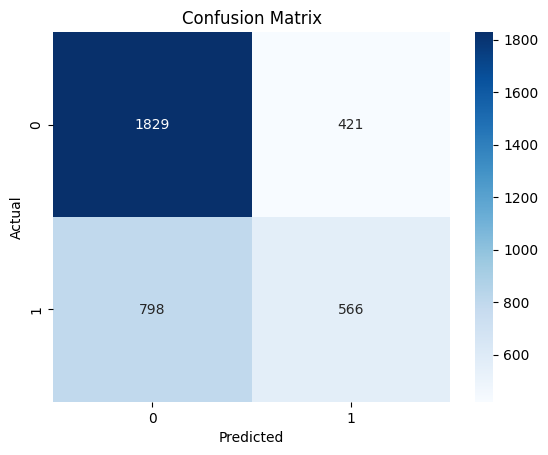

In [275]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(combined["actual"], combined["prediction"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [276]:
# Legacy visualisation removed – see multi-class section below for updated confusion matrix output.

## Multi-class kick-off style predictions


In [277]:
if "matches_model" not in globals() or "feature_cols" not in globals():
    raise RuntimeError("Run the feature-engineering cells above to build matches_model and feature_cols before training the multi-class model.")

home_rows_full = matches_rolling[matches_rolling["venue_code"] == 0].copy()
home_rows_full["result_label"] = home_rows_full["team_result"].map({"W": 0, "D": 1, "L": 2})

home_rows = matches_model[matches_model["venue_code"] == 0].copy()
home_rows["result_label"] = home_rows["team_result"].map({"W": 0, "D": 1, "L": 2})

parity_specs = [
    ("season_points_to_date", "opp_season_points_to_date", "season_points_gap"),
    ("season_goal_diff_to_date", "opp_season_goal_diff_to_date", "season_goal_diff_gap"),
    ("season_points_rate", "opp_season_points_rate", "season_points_rate_gap"),
    ("matches_played", "opp_matches_played", "matches_played_gap")
]
for left, right, new_name in parity_specs:
    home_rows[new_name] = home_rows[left] - home_rows[right]

multiclass_extra_features = [spec[2] for spec in parity_specs]
multiclass_feature_cols = [col for col in feature_cols if col != "venue_code"] + multiclass_extra_features
len(multiclass_feature_cols)


71

In [278]:
multi_split_date = "2017-01-01"
multiclass_train = home_rows[home_rows["Date"] < multi_split_date].copy()
multiclass_test = home_rows[home_rows["Date"] >= multi_split_date].copy()

class_counts = multiclass_train["result_label"].value_counts().sort_index()
num_classes = class_counts.shape[0]
train_size = len(multiclass_train)
class_weight_map = {
    cls: train_size / (num_classes * count) for cls, count in class_counts.items()
}
multiclass_train_weights = multiclass_train["result_label"].map(class_weight_map)

class_counts, class_weight_map


(result_label
 0    2816
 1    1544
 2    1699
 Name: count, dtype: int64,
 {0: 0.7172111742424242, 1: 1.3080742659758204, 2: 1.1887384736119286})

In [279]:
multiclass_predictors = multiclass_feature_cols
len(multiclass_predictors)


71

In [280]:
train_sorted = multiclass_train.sort_values("Date").copy()
val_split_point = int(len(train_sorted) * 0.8)
train_sub = train_sorted.iloc[:val_split_point]
val_sub = train_sorted.iloc[val_split_point:]
train_weights_sub = multiclass_train_weights.loc[train_sub.index]

multi_model = xgb.XGBClassifier(
    n_estimators=800,
    max_depth=6,
    learning_rate=0.04,
    subsample=0.9,
    colsample_bytree=0.9,
    min_child_weight=4,
    reg_lambda=1.2,
    reg_alpha=0.2,
    gamma=0.25,
    objective="multi:softprob",
    num_class=3,
    eval_metric="mlogloss",
    random_state=42,
    n_jobs=-1
)

multi_model.fit(
    train_sub[multiclass_predictors],
    train_sub["result_label"],
    sample_weight=train_weights_sub,
    eval_set=[(val_sub[multiclass_predictors], val_sub["result_label"])],
    verbose=False,
)

multi_probs = multi_model.predict_proba(multiclass_test[multiclass_predictors])
multi_preds = multi_probs.argmax(axis=1)

tscv = TimeSeriesSplit(n_splits=5)
cv_scores = []
for tr_idx, va_idx in tscv.split(train_sorted):
    X_tr = train_sorted.iloc[tr_idx][multiclass_predictors]
    y_tr = train_sorted.iloc[tr_idx]["result_label"]
    X_va = train_sorted.iloc[va_idx][multiclass_predictors]
    y_va = train_sorted.iloc[va_idx]["result_label"]
    w_tr = multiclass_train_weights.loc[train_sorted.iloc[tr_idx].index]
    cv_model = xgb.XGBClassifier(
        n_estimators=600,
        max_depth=5,
        learning_rate=0.04,
        subsample=0.9,
        colsample_bytree=0.9,
        min_child_weight=4,
        objective="multi:softprob",
        num_class=3,
        eval_metric="mlogloss",
        random_state=42,
        n_jobs=-1
    )
    cv_model.fit(
        X_tr, y_tr,
        sample_weight=w_tr,
        eval_set=[(X_va, y_va)],
        verbose=False,
    )
    va_preds = cv_model.predict(X_va)
    cv_scores.append(accuracy_score(y_va, va_preds))

cv_mean_accuracy = float(np.mean(cv_scores))

multi_model


,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.9
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [281]:
multi_acc = accuracy_score(multiclass_test["result_label"], multi_preds)
multi_logloss = log_loss(multiclass_test["result_label"], multi_probs)

{
    "accuracy": multi_acc,
    "log_loss": multi_logloss,
    "cv_mean_accuracy": cv_mean_accuracy
}


{'accuracy': 0.5005038629492778,
 'log_loss': 1.0779438284016247,
 'cv_mean_accuracy': 0.48582755203171457}

In [282]:
SAVE_MODEL = True # Set to True to save the model

if SAVE_MODEL:
    MODEL_DIR = Path("model")
    MODEL_DIR.mkdir(exist_ok=True)
    MODEL_PATH = MODEL_DIR / "model.joblib"

    joblib.dump(multi_model, MODEL_PATH)
    print(f"Model saved to {MODEL_PATH}")
else:
    print("Model saving skipped.")


Model saved to model\model.joblib


In [283]:
print(
    classification_report(
        multiclass_test["result_label"],
        multi_preds,
        target_names=["Home Win", "Draw", "Away Win"]
    )
)


              precision    recall  f1-score   support

    Home Win       0.53      0.71      0.61      1324
        Draw       0.29      0.12      0.17       692
    Away Win       0.50      0.48      0.49       961

    accuracy                           0.50      2977
   macro avg       0.44      0.44      0.43      2977
weighted avg       0.47      0.50      0.47      2977



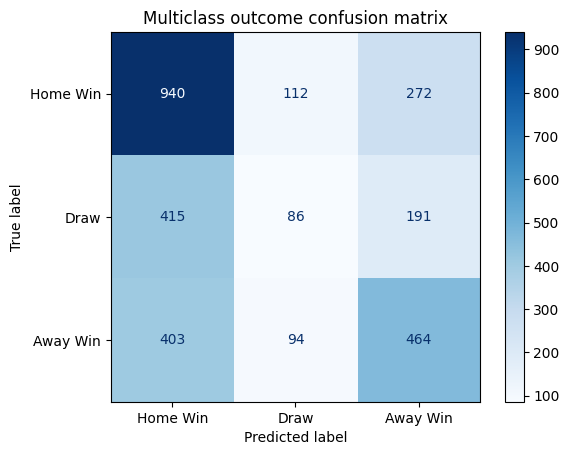

,Pred Home,Pred Draw,Pred Away
Actual Home,71.0,8.5,20.5
Actual Draw,60.0,12.4,27.6
Actual Away,41.9,9.8,48.3


In [284]:
cm = confusion_matrix(multiclass_test["result_label"], multi_preds)
cm_percent = (cm / cm.sum(axis=1, keepdims=True) * 100).round(1)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Home Win", "Draw", "Away Win"]
)
disp.plot(cmap="Blues")
plt.title("Multiclass outcome confusion matrix")
plt.show()

pd.DataFrame(
    cm_percent,
    columns=["Pred Home", "Pred Draw", "Pred Away"],
    index=["Actual Home", "Actual Draw", "Actual Away"]
)


<Figure size 1200x600 with 0 Axes>

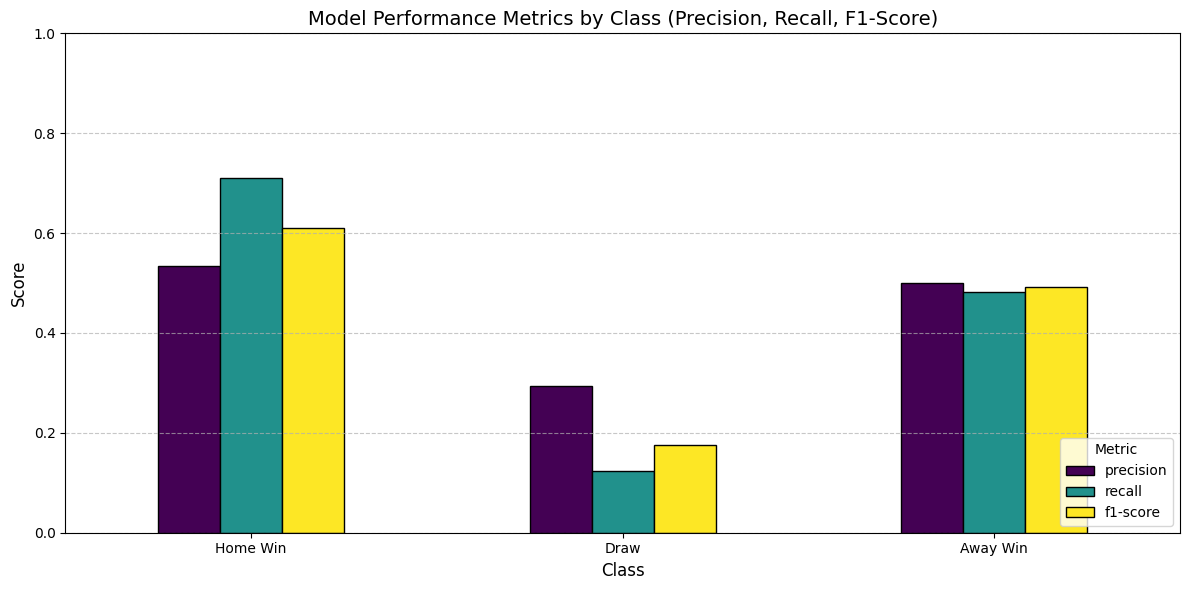

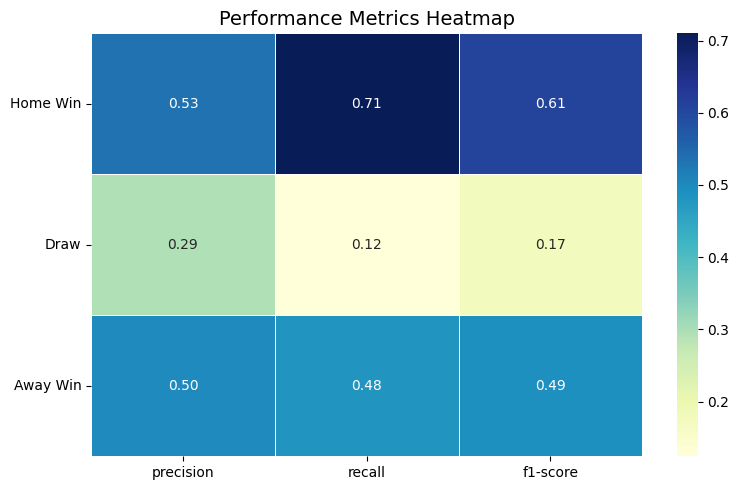

In [285]:
# Enhanced Visualization of Model Accuracy
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Generate classification report with proper class names
target_names = ["Home Win", "Draw", "Away Win"]
report = classification_report(multiclass_test["result_label"], multi_preds, target_names=target_names, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# 1. Bar Chart for Per-Class Metrics
plt.figure(figsize=(12, 6))
metrics_df = df_report.loc[target_names, ["precision", "recall", "f1-score"]]
metrics_df.plot(kind='bar', figsize=(12, 6), colormap='viridis', edgecolor='black')
plt.title("Model Performance Metrics by Class (Precision, Recall, F1-Score)", fontsize=14)
plt.ylabel("Score", fontsize=12)
plt.xlabel("Class", fontsize=12)
plt.xticks(rotation=0)
plt.ylim(0, 1.0)
plt.legend(loc='lower right', title="Metric")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 2. Heatmap for a compact view
plt.figure(figsize=(8, 5))
sns.heatmap(metrics_df, annot=True, cmap="YlGnBu", fmt=".2f", linewidths=.5)
plt.title("Performance Metrics Heatmap", fontsize=14)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [286]:
prob_cols = ["home_win_pct", "draw_pct", "away_win_pct"]
prob_df = pd.DataFrame(multi_probs, columns=prob_cols)
prob_df = (prob_df * 100).round(2)

outcome_lookup = {0: "Home Win", 1: "Draw", 2: "Away Win"}

multi_results = multiclass_test.reset_index(drop=True)[["Date", "Team", "Opponent", "result_label"]].copy()
multi_results = multi_results.rename(columns={"Team": "HomeTeam", "Opponent": "AwayTeam"})
multi_results[prob_cols] = prob_df
multi_results["predicted_outcome"] = pd.Series(multi_preds).map(outcome_lookup)
multi_results["actual_outcome"] = multi_results["result_label"].map(outcome_lookup)

multi_results.head()


,Date,HomeTeam,AwayTeam,result_label,home_win_pct,draw_pct,away_win_pct,predicted_outcome,actual_outcome
0,2017-01-01,Arsenal,Crystal Palace,0,74.269997,7.300000,18.430000,Home Win,Home Win
1,2017-01-01,Watford,Tottenham,2,20.000000,9.200000,70.800003,Away Win,Away Win
2,2017-01-02,Man United,Hull,1,71.980003,19.850000,8.170000,Home Win,Draw
3,2017-01-02,Stoke,Everton,1,27.850000,48.209999,23.940001,Draw,Draw
4,2017-01-02,West Ham,Man City,2,25.740000,31.920000,42.340000,Away Win,Away Win


In [287]:
def predict_match_outcome(home_team: str, away_team: str, match_date: str | None = None):
    """
    Predict the outcome probabilities for a specific fixture.

    Parameters
    ----------
    home_team : str
        Name of the home team.
    away_team : str
        Name of the away team.
    match_date : str | None
        Optional ISO date string. If provided, selects the closest fixture on or after
        that date. Otherwise the most recent historical match between the two teams is used.
    """
    if "home_rows_full" not in globals():
        raise RuntimeError("Please run the feature engineering cells to populate home_rows_full before calling this helper.")

    def _filter_candidates(df):
        mask = (
            (df["Team"].str.lower() == home_team.lower()) & (df["Opponent"].str.lower() == away_team.lower())
        )
        return df.loc[mask].copy()

    candidates = _filter_candidates(home_rows)
    backup_candidates = _filter_candidates(home_rows_full)
    original_candidates = candidates.copy()
    original_backup = backup_candidates.copy()
    fallback_note = None

    if match_date:
        match_date = pd.to_datetime(match_date)
        candidates = candidates[candidates["Date"] >= match_date]
        backup_candidates = backup_candidates[backup_candidates["Date"] >= match_date]
        if candidates.empty and backup_candidates.empty:
            if original_candidates.empty and original_backup.empty:
                raise ValueError(f"No fixtures for {home_team} vs {away_team} in the available dataset.")
            candidates = original_candidates
            backup_candidates = original_backup
            fallback_note = (
                f"No fixture on or after {match_date.date()} – using most recent historical head-to-head."
            )

    if candidates.empty and backup_candidates.empty:
        raise ValueError(f"No fixtures for {home_team} vs {away_team} in the available dataset.")

    source = candidates if not candidates.empty else backup_candidates
    latest_fixture = source.sort_values("Date").tail(1).copy()
    used_backup = candidates.empty

    latest_fixture = latest_fixture.fillna(0)
    fixture_probs = multi_model.predict_proba(latest_fixture[multiclass_predictors])
    fixture_prob_df = pd.DataFrame(fixture_probs, columns=prob_cols)
    fixture_prob_df = (fixture_prob_df * 100).round(2)
    fixture_pred_idx = fixture_probs.argmax(axis=1)

    fixture_display = latest_fixture[["Date", "Team", "Opponent", "result_label"]].rename(
        columns={"Team": "HomeTeam", "Opponent": "AwayTeam"}
    ).reset_index(drop=True)
    fixture_display[prob_cols] = fixture_prob_df.values
    fixture_display["predicted_outcome"] = pd.Series(fixture_pred_idx).map(outcome_lookup)
    fixture_display["actual_outcome"] = fixture_display["result_label"].map(outcome_lookup)

    note_messages = []
    if used_backup:
        note_messages.append("Row constructed from full history (possible NA fill).")
    if fallback_note:
        note_messages.append(fallback_note)
    if note_messages:
        fixture_display["note"] = " | ".join(note_messages)

    return fixture_display


In [288]:
multi_results.sort_values("Date").tail()


,Date,HomeTeam,AwayTeam,result_label,home_win_pct,draw_pct,away_win_pct,predicted_outcome,actual_outcome
2974,2025-11-09,Crystal Palace,Brighton,1,66.839996,20.360001,12.810000,Home Win,Draw
2975,2025-11-09,Man City,Liverpool,0,41.320000,36.340000,22.340000,Home Win,Home Win
2972,2025-11-09,Aston Villa,Bournemouth,0,39.400002,30.730000,29.870001,Home Win,Home Win
2973,2025-11-09,Brentford,Newcastle,0,21.760000,10.880000,67.360001,Away Win,Home Win
2976,2025-11-09,Nott'm Forest,Leeds,0,45.250000,18.020000,36.730000,Home Win,Home Win


In [289]:
fixture_candidates = home_rows[
    (
        (home_rows["Team"] == "Liverpool") & (home_rows["Opponent"] == "Man United")
    ) |
    (
        (home_rows["Team"] == "Man United") & (home_rows["Opponent"] == "Liverpool")
    )
].copy()

from IPython.display import display

backup_candidates = home_rows_full[
    (
        (home_rows_full["Team"] == "Liverpool") & (home_rows_full["Opponent"] == "Man United")
    ) |
    (
        (home_rows_full["Team"] == "Man United") & (home_rows_full["Opponent"] == "Liverpool")
    )
].copy()

try:
    fixture_display = predict_match_outcome("Liverpool", "Man United")
    display(fixture_display)
except ValueError as exc:
    print(exc)


,Date,HomeTeam,AwayTeam,result_label,home_win_pct,draw_pct,away_win_pct,predicted_outcome,actual_outcome
0,2025-10-19,Liverpool,Man United,2,74.419998,12.56,13.02,Home Win,Away Win


In [290]:
# Forecast one of the upcoming EPL fixtures using the latest model
try:
    upcoming_prediction = predict_match_outcome(
        home_team="Arsenal",
        away_team="Chelsea",
        match_date="2025-08-15"
    )
    display(upcoming_prediction)
except ValueError as exc:
    print(f"Could not generate upcoming fixture prediction: {exc}")


,Date,HomeTeam,AwayTeam,result_label,home_win_pct,draw_pct,away_win_pct,predicted_outcome,actual_outcome,note
0,2025-03-16,Arsenal,Chelsea,0,76.169998,11.32,12.51,Home Win,Home Win,No fixture on or after 2025-08-15 – using most...
